In [16]:
import numpy as np
import matplotlib.pyplot as plt

from yaglm.toy_data import sample_sparse_lin_reg

from yaglm.Glm import Glm
from yaglm.GlmTuned import GlmCV

from yaglm.config.penalty import Lasso, Ridge
from yaglm.config.flavor import Adaptive, NonConvex
from yaglm.solver.LLA import LLAFixedInit

In [2]:
# sample data from a toy linear regression model
X, y, model_info = sample_sparse_lin_reg(n_samples=100,
                                         n_features=10,
                                         beta_type=1,
                                         random_state=1)

# Adaptive Lasso

Every convex, non-smooth penalty can come in an adaptive flavor.

In [3]:
# linear regression with an adaptive Lasso
adaptive_lasso = Glm(penalty=Lasso(pen_val=1, flavor=Adaptive()) # flavor is apart of the penalty
                    ).fit(X, y)


# the Adaptive() config can set the exponent parameter
adaptive_lasso = Glm(penalty=Lasso(pen_val=1, flavor=Adaptive(expon=0.5)) 
                    ).fit(X, y)


# tune adaptive Lasso with cross-validation
adaptive_lasso = GlmCV(penalty=Lasso(flavor=Adaptive())
                       ).fit(X, y)

In [4]:
# adaptive estimators are two stage estimators that require 
# fit fitting an initializer. By default the initializer is the same estimator
# but with flavor=None

GlmCV(penalty=Lasso(flavor=Adaptive()),
      initializer='default'  # this is the default argument
     )

# this is the same estimator as above
GlmCV(penalty=Lasso(flavor=Adaptive()),
      initializer=GlmCV(penalty=Lasso())  # this will be the default
     )

# but you can of course provide your own custom initializers e.g.
initializer = GlmCV(penalty=Lasso(),
                    cv=10 # use 10 fold CV instead of the default 5 folds
                    )  #.fit(X, y) Optinally fit ahead of time

GlmCV(penalty=Lasso(flavor=Adaptive()),
      initializer=initializer
     )


GlmCV(initializer=GlmCV(cv=10,
                        penalty=<yaglm.config.penalty.Lasso object at 0x7f85025bdbd0>),
      penalty=<yaglm.config.penalty.Lasso object at 0x7f85025bdb10>)

# Tuning the flavor

In [5]:
# we can tune over both the penalty value and the adaptive exponent
expon_seq = [1, .5, 0.25]
penalty = Lasso(flavor=Adaptive().tune(expon=expon_seq))
              
adaptive_lasso = GlmCV(penalty=penalty).fit(X, y)

# Non-convex penalties

There are two ways we handle non-convex penalties

- LLA algorithm from a fixed initializer, see (Fan et al, 2014)
- Direct solution; run something like proximal gradient or coordinate descent directly only the non-convex problem.

For the LLA algorithm we require a "good enough" initializer; this is typically a tuned Lasso. For the direct solution we give the optional to either use a good initializer or a naive initializer (e.g. zero).

### LLA

In [6]:
# Use the LLA algorithm with a good initializer
# note by default we only take 1 LLA step
est = GlmCV(penalty=Lasso(flavor=NonConvex()),
            lla=True,
            initializer='default' # this will tune a Lasso via cross-validation
            ).fit(X, y)


In [7]:
# the non-convex function can be specified in the flavor 
penalty = Lasso(pen_val=1,
                flavor=NonConvex(pen_func='scad',
                                 second_param_val=3.7) # this is the a parameter
               )

# the LLA algorithm can also be specified in the flavor
Glm(penalty=penalty,
    lla=LLAFixedInit(n_steps=100, atol=1e-5)  # take more than 1 LLA steps
    ).fit(X, y)

Glm(lla=<yaglm.solver.LLA.LLAFixedInit object at 0x7f8502724050>,
    penalty=<yaglm.config.penalty.Lasso object at 0x7f8502724350>)

In [8]:
# we can tune over the flavor's second_param_val
# e.g. this is the a parameter to scad
param_val_seq = np.arange(3, 8)
flavor = NonConvex().tune(second_param_val=param_val_seq)

est = GlmCV(penalty=Lasso(flavor=flavor))

### Direct

In [9]:
# non-convex direct solution
# here we use FISTA directly on the non-convex problem
# by default we initialize from zero
est = GlmCV(penalty=Lasso(flavor=NonConvex()),
            lla=False, # use the FISTA solver, not the LLA algorithm
            initializer='default' # this will initializer from zero by default
            ).fit(X, y)

# Comparison


In [10]:
from time import time
import pandas as pd

from yaglm.infer.Inferencer import Inferencer 
from yaglm.metrics.info_criteria import InfoCriteria
from yaglm.GlmTuned import GlmTrainMetric

In [11]:
# sample data from a toy linear regression model
# play around with this toy distribution and see what happens!
X, y, model_info = sample_sparse_lin_reg(n_samples=100, n_features=10,
                                         n_nonzero=5,
                                         beta_type=1, snr=5,
                                         random_state=1)

true_coef = model_info['coef']
sigma_true = model_info['noise_std']

In [12]:
# use Lasso CV as initializer for all two stage algorithms
lasso_cv = GlmCV(penalty=Lasso(), n_jobs=-1)

# the congergence LLA algorithm
lla_converge = LLAFixedInit(n_steps=1000)


crit = 'ebic'
models = {
    
         ###############################
         # Cross-validation selection #
         ##############################

         # Adaptive Lasso
         'adpt_lasso_cv': GlmCV(penalty=Lasso(flavor=Adaptive()),
                                initializer=lasso_cv,
                                n_jobs=-1),

         # LLA with 1 LLA step
         'nc_lla_1_cv': GlmCV(penalty=Lasso(flavor=NonConvex()),
                              lla=True,
                              initializer=lasso_cv,
                              n_jobs=-1),

         # LLA with many steps (hopfully to convergence)
         'nc_lla_many_cv': GlmCV(penalty=Lasso(flavor=NonConvex()),
                                 lla=lla_converge,
                                 initializer=lasso_cv,
                                 n_jobs=-1),
    
          # Non-convex direction, init from zero
          'nc_direct_0_cv': GlmCV(penalty=Lasso(flavor=NonConvex()),
                                  lla=False,
                                  initializer='zero',
                                  n_jobs=-1),
    
          # Non-convex direction, init from lasso
          'nc_direct_lasso_cv': GlmCV(penalty=Lasso(flavor=NonConvex()),
                                      lla=False,
                                      initializer=lasso_cv,
                                      n_jobs=-1),


         #######################
         # Infomation criteria #
         #######################
         # we will cheat and assume we know the true noise standard deviation

        'lasso_ebic': GlmTrainMetric(penalty=Lasso(),
                                     n_jobs=-1,
                                          
                                     inferencer = Inferencer(scale=sigma_true),
                                     scorer = InfoCriteria(crit=crit)
                                     ),
    

        'adpt_lasso_ebic': GlmTrainMetric(penalty=Lasso(flavor=Adaptive()),
                                          initializer=lasso_cv,
                                          n_jobs=-1,
                                          
                                          inferencer = Inferencer(scale=sigma_true),
                                          scorer = InfoCriteria(crit=crit)
                                          ),
    
        'nc_lla_1_ebic': GlmTrainMetric(penalty=Lasso(flavor=NonConvex()),
                                        lla=True,
                                        initializer=lasso_cv,
                                        n_jobs=-1,
                                          
                                         inferencer = Inferencer(scale=sigma_true),
                                         scorer = InfoCriteria(crit=crit)
                                         ),
    
        'nc_lla_many_ebic': GlmTrainMetric(penalty=Lasso(flavor=NonConvex()),
                                           lla=lla_converge,

                                            initializer=lasso_cv,
                                            n_jobs=-1,
                                          
                                            inferencer = Inferencer(scale=sigma_true),
                                            scorer = InfoCriteria(crit=crit)
                                            ),
    

        'nc_direct_0_ebic': GlmTrainMetric(penalty=Lasso(flavor=NonConvex()),
                                           lla=False,
                                           initializer='zero',
                                           n_jobs=-1,

                                           inferencer = Inferencer(scale=sigma_true),
                                           scorer = InfoCriteria(crit=crit)
                                           ),
    
        'nc_direct_lasso_ebic': GlmTrainMetric(penalty=Lasso(flavor=NonConvex()),
                                               lla=False,
                                               initializer=lasso_cv,
                                               n_jobs=-1,
                                          
                                               inferencer = Inferencer(scale=sigma_true),
                                               scorer = InfoCriteria(crit=crit)
                                              )

         }

In [13]:
runtimes = {} 

# fit initializer first
start_time = time()
lasso_cv = lasso_cv.fit(X, y)
runtimes['lasso_cv'] = time() - start_time

# fit each estimator
for name, est in models.items():
    start_time = time()
    est.fit(X, y)
    runtimes[name] = time() - start_time
    
models['lasso_cv'] = lasso_cv

pd.Series(runtimes, name='runtime').sort_values()

lasso_ebic              0.226763
adpt_lasso_ebic         0.319477
nc_lla_1_ebic           0.326648
nc_direct_0_ebic        0.379684
nc_direct_lasso_ebic    0.434885
nc_lla_many_ebic        0.692485
adpt_lasso_cv           1.341425
nc_lla_1_cv             1.523784
lasso_cv                1.546310
nc_direct_lasso_cv      2.400652
nc_direct_0_cv          2.617115
nc_lla_many_cv          5.769942
Name: runtime, dtype: float64

In [14]:
# compute L1 error from estimate to truth
coef_errs = {}
for name, est in models.items():
    coef_errs[name] = abs(est.coef_ - true_coef).sum()
    
    
pd.Series(coef_errs, name='coefficient error').sort_values()

lasso_ebic              0.466964
adpt_lasso_cv           0.482867
adpt_lasso_ebic         0.496128
nc_lla_many_cv          0.496320
nc_lla_1_ebic           0.496401
nc_direct_0_ebic        0.496414
nc_direct_lasso_ebic    0.496414
nc_lla_many_ebic        0.496414
lasso_cv                0.525913
nc_lla_1_cv             0.528743
nc_direct_0_cv          0.543311
nc_direct_lasso_cv      0.694087
Name: coefficient error, dtype: float64

Text(0.5, 1.0, 'Estimated Coefficients')

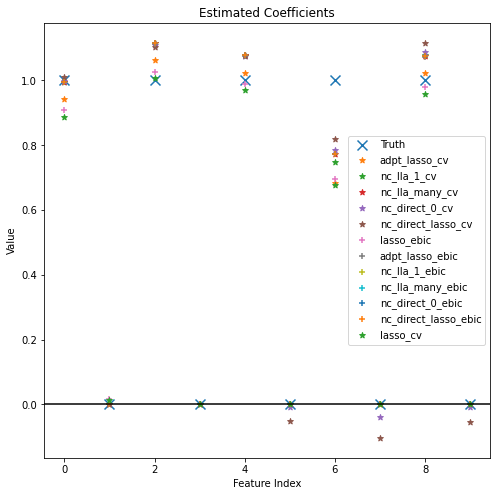

In [15]:
# plot estimated coefficients
# Ok I've made better plots in my life, but this is just for quick illustration purposes!
idxs = np.arange(len(true_coef))

plt.figure(figsize=(8, 8))
plt.scatter(idxs, true_coef, label='Truth', marker='x', s=100)


for name, est in models.items():
    if name.endswith("cv"):
        marker = '*'
    else:
        marker = '+'
    
    plt.scatter(idxs, est.coef_, label=name, marker=marker)
    
    
plt.legend()
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.axhline(0, color='black')

plt.title("Estimated Coefficients")